<a href="https://colab.research.google.com/github/truongthuanr/self-project/blob/main/08_SSSMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns
from random import randint
from urllib.request import urlopen
from numpy import asarray

In [3]:
train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)


total_images = df.thumbnail_url.notna().sum()
# total_images

# There are some in consistency in our data,
# convert the ' ' label to NaN for later process
df.loc[df["cloth_type"]==' ',"cloth_type"] = np.NaN

# create a list of list of labels 
labels = df.cloth_type.str.split(" ").tolist()
# Flatten the label list to get all count of label
labels = [item if type(item) == list else [str(item)] for item in labels]


# Count the apperence of label
all_label = [label for sub in labels for label in sub]
labels_count = Counter(all_label)


labels_count = Counter(all_label)
# Get the name and number if its appereace in our data
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]


# Create map of labels for classification
# To transform label to vector for training
# and invert from vector to label after predict
label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}
inv_label_map

{0: 'top_t-shirt_sweatshirt',
 1: 'pants',
 2: 'shoe',
 3: 'dress',
 4: 'skirt',
 5: 'shirt_blouse',
 6: 'shorts',
 7: 'watch',
 8: 'bag_wallet',
 9: 'jacket',
 10: 'belt',
 11: 'nan',
 12: 'hat',
 13: 'coat',
 14: 'glasses',
 15: 'sweater',
 16: 'headband_head-covering_hair-accessory',
 17: 'cardigan',
 18: 'jumpsuit',
 19: 'scarf',
 20: 'vest'}

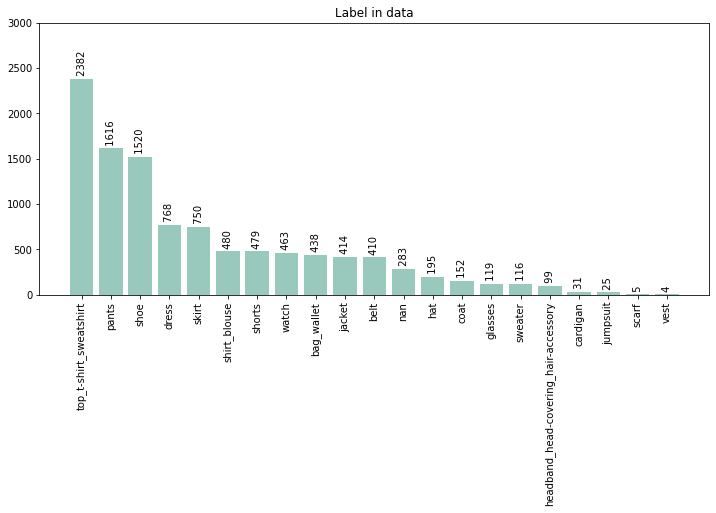

In [4]:
# Visual the labels with its frequency

# ploting
fig = plt.figure(figsize=(12,5))
plt.bar(label_name, label_freq, color="#99C8BC")
plt.title("Label in data")
plt.xticks(rotation=90)

# Add more text and value
for i, (tag,count) in enumerate(labels_count.most_common()):
  plt.text(i, count, f" {count} ", rotation=90, ha="center", va="bottom", color="black")
plt.ylim(0,3000);

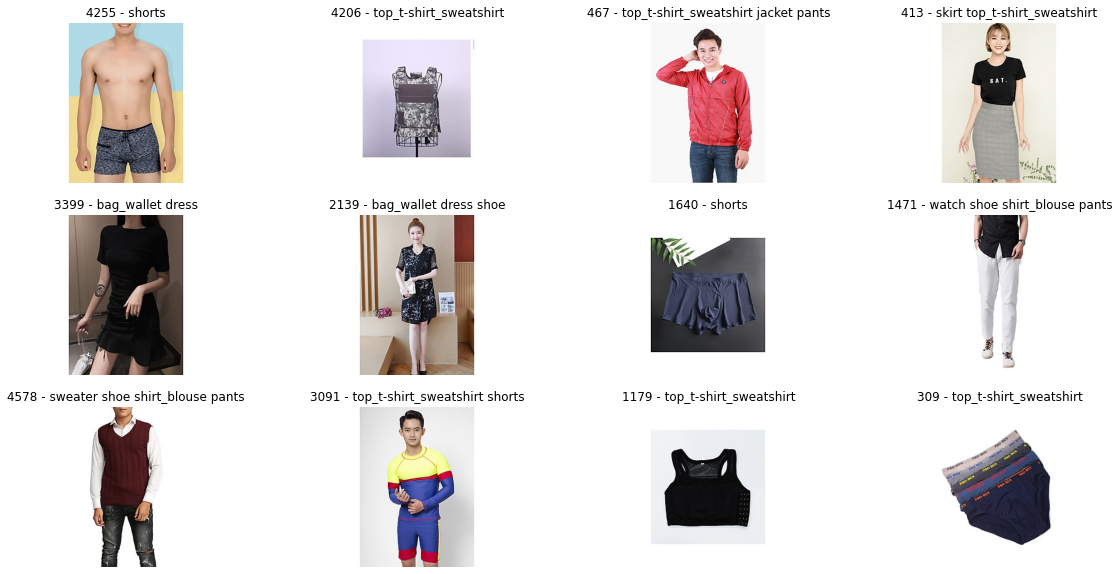

In [5]:
# Check for random image and its label
fig = plt.figure(figsize=(20,10))
for i in range(0,12):
  ax = plt.subplot(3,4,i+1)
  _i = randint(0,total_images)
  img = Image.open(urlopen(df.thumbnail_url[_i]))
  ax = plt.imshow(img)
  plt.title(f"{_i} - {df.cloth_type[_i]}")
  plt.axis("off")


In [6]:
# Create a encoder function 
# to transform label to vector
def one_hot_encoder(tags, mapping):
  # create empty vector
  encoding = np.zeros(len(label_map), dtype="uint")
  # mark 1 for each tag in the vector
  for tag in tags:
    encoding[label_map[tag]] = 1
  return encoding

In [7]:
# Create a funtion to load ourdata set
# - Reading image from url
# - Turn image to array
# - Encode the label

def load_dataset(images_url, labels, label_map):
  # images,  targets = list(), list()
  images = []
  targets = []
  for i in range(0,len(images_url)):
    # load_img
    img = Image.open(urlopen(images_url[i]))
    if img.mode != 'RGB': img = img.convert('RGB')

    # turn image in to array
    img = asarray(img)
    tags = labels[i]
    target = one_hot_encoder(tags, label_map)

    images.append(img)
    targets.append(target)

  X = asarray(images, dtype="uint8")
  y = asarray(targets, dtype="uint8")

  return X, y

In [8]:
# This is load the dataset and save it for later use
# This step is excute one time

# X, y = load_dataset(df.thumbnail_url, labels, label_map)
# np.savez_compressed("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna_21.npz", X, y)

In [9]:
# Loading the test set for predicting
test_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/test.csv"
df1 = pd.read_csv(test_url)

def load_testset(images_url):
  # images,  targets = list(), list()
  images = []
  for i in range(0,len(images_url)):
    # load_img
    img = Image.open(urlopen(images_url[i]))
    img = img.convert("RGB")
    # turn image in to array
    img = asarray(img)

    images.append(img)

  X_test = asarray(images, dtype="uint8")
  return X_test

# This is load the dataset and save it for later use
# This step is excute one time
# data_test = load_testset(df1.thumbnail_url)
# np.savez_compressed("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz", data_test)

# Model

In [10]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Create a function to calculate the mean fscore

def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [12]:
in_shape = (280,280,3)
out_shape = 21

In [13]:
model = EfficientNetB3(include_top=False,
                       input_shape = in_shape)
for layer in model.layers:
  layer.trainable = False

for layer in model.layers[-20:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer="he_uniform")(flat1)
output = Dense(out_shape, activation="sigmoid")(class1)

model = Model(inputs=model.inputs, outputs=output)

# compile model
opt = SGD(learning_rate=0.003, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

43950080/43941136 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 280, 280, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 280, 280, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 280, 280, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 281, 281, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [15]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 21)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)
datagen = ImageDataGenerator()
train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)

In [17]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=30)

Epoch 1/30
50/50 [==============================] - 109s 1s/step - loss: 0.2457 - fbeta: 0.4961 - val_loss: 0.1783 - val_fbeta: 0.5818
Epoch 2/30
50/50 [==============================] - 59s 1s/step - loss: 0.1458 - fbeta: 0.6734 - val_loss: 0.1651 - val_fbeta: 0.6040
Epoch 3/30
50/50 [==============================] - 59s 1s/step - loss: 0.1202 - fbeta: 0.7371 - val_loss: 0.1614 - val_fbeta: 0.6340
Epoch 4/30
50/50 [==============================] - 59s 1s/step - loss: 0.1021 - fbeta: 0.7748 - val_loss: 0.1599 - val_fbeta: 0.6314
Epoch 5/30
50/50 [==============================] - 59s 1s/step - loss: 0.0862 - fbeta: 0.8195 - val_loss: 0.1595 - val_fbeta: 0.6503
Epoch 6/30
50/50 [==============================] - 59s 1s/step - loss: 0.0753 - fbeta: 0.8490 - val_loss: 0.1584 - val_fbeta: 0.6518
Epoch 7/30
50/50 [==============================] - 59s 1s/step - loss: 0.0658 - fbeta: 0.8687 - val_loss: 0.1611 - val_fbeta: 0.6590
Epoch 8/30
50/50 [==============================] - 59s 1s/st

In [18]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_EffB3_f/model_EfficientNetB3_f')

In [19]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")

Loaded: (1505, 280, 280, 3)


In [20]:
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [22]:
loss, fbeta = model.evaluate(test_it, steps=len(test_it))
print(f"> loss = {loss:.3f}, f1-mean = {fbeta:.3f}")

25/25 [==============================] - 18s 703ms/step - loss: 0.2137 - fbeta: 0.6576
> loss = 0.214, f1-mean = 0.658


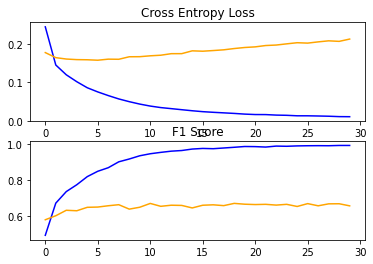

In [23]:
summarize_diagnostics(history)

In [24]:
predictions = model.predict(test_data)

def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags

prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]
prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

In [25]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

submission["cloth_type"] = submission.cloth_type.str.replace("nan","")

In [26]:
submission.to_csv('/content/drive/MyDrive/01_AI_ML/sss/v11_Eff.csv', index=False)